# EDA

In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib notebook

In [ ]:
from matplotlib.ticker import MaxNLocator
from scipy import ndimage
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

In [3]:
csvfile = "meetings_complete.csv"

In [4]:
df = pd.read_csv(csvfile)

In [5]:
df.head()

,Name,Day,Time,Video,Desc,Categories,Email,Phone
0,1 Hole in the Sky AA Meetings: AA Secular Dail...,Tuesday,5:00 pm,https://zoom.us/j/414948190,Tuesday: AA Secular Daily Reflections 3:00pm P...,"Audio,Open,Video",NaN,NaN
1,AA Friends,Tuesday,5:00 pm,https://aafriends.webs.com/,AA Friends currently holds three online meetin...,"Forum,Open",aafriends@usa.com,NaN
2,AA New Beginnings,Tuesday,5:00 pm,https://us02web.zoom.us/j/5662326551,"A daily meeting that focuses on experience, st...","Audio,Big Book,Discussion,Open,Video",AANewBeginnings230@gmail.com,NaN
3,Agnes Water,Tuesday,5:00 pm,https://us02web.zoom.us/j/8983968244,PW billw,"Big Book,Discussion,Speaker,Video",agneswaterxa@gmail.com,NaN
4,Beginners AA meeting,Tuesday,5:00 pm,https://us02web.zoom.us/j/88198562544?pwd=WFZm...,"Zoom Passcode, if any: serenity","Big Book,Discussion,Open,Speaker,Video",liaazoom2020@gmail.com,NaN


### Transforming

##### Convert 'Time' column to datetime data type

In [6]:
pd.to_datetime(df["Time"]).dt.time

0       17:00:00
1       17:00:00
2       17:00:00
3       17:00:00
4       17:00:00
          ...   
4162         NaT
4163         NaT
4164         NaT
4165         NaT
4166         NaT
Name: Time, Length: 4167, dtype: object

In [7]:
# dt.normalize() sets time component to 00:00:00, so here we're subtracting the days
pd.to_datetime(df["Time"]) - pd.to_datetime(df["Time"]).dt.normalize()

0      17:00:00
1      17:00:00
2      17:00:00
3      17:00:00
4      17:00:00
         ...   
4162        NaT
4163        NaT
4164        NaT
4165        NaT
4166        NaT
Name: Time, Length: 4167, dtype: timedelta64[ns]

In this case, it may be that the time data would be better analyzed as categorical. But since there is an ordinal component to it ("how many of this earlier in the day or that later in the day?"), let's just save both versions.

In [8]:
df["Time_dt"] = pd.to_datetime(df["Time"]).dt.time
df["Time_del"] = pd.to_datetime(df["Time"]) - pd.to_datetime(df["Time"]).dt.normalize()
df.head()

,Name,Day,Time,Video,Desc,Categories,Email,Phone,Time_dt,Time_del
0,1 Hole in the Sky AA Meetings: AA Secular Dail...,Tuesday,5:00 pm,https://zoom.us/j/414948190,Tuesday: AA Secular Daily Reflections 3:00pm P...,"Audio,Open,Video",NaN,NaN,17:00:00,17:00:00
1,AA Friends,Tuesday,5:00 pm,https://aafriends.webs.com/,AA Friends currently holds three online meetin...,"Forum,Open",aafriends@usa.com,NaN,17:00:00,17:00:00
2,AA New Beginnings,Tuesday,5:00 pm,https://us02web.zoom.us/j/5662326551,"A daily meeting that focuses on experience, st...","Audio,Big Book,Discussion,Open,Video",AANewBeginnings230@gmail.com,NaN,17:00:00,17:00:00
3,Agnes Water,Tuesday,5:00 pm,https://us02web.zoom.us/j/8983968244,PW billw,"Big Book,Discussion,Speaker,Video",agneswaterxa@gmail.com,NaN,17:00:00,17:00:00
4,Beginners AA meeting,Tuesday,5:00 pm,https://us02web.zoom.us/j/88198562544?pwd=WFZm...,"Zoom Passcode, if any: serenity","Big Book,Discussion,Open,Speaker,Video",liaazoom2020@gmail.com,NaN,17:00:00,17:00:00


##### Weekdays are ordered categorical data

In [9]:
from pandas.api.types import CategoricalDtype
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Ongoing']
day_type = CategoricalDtype(categories=days, ordered=True)
df['Day'] = df['Day'].astype(day_type)

##### Create new columns from category labels

In [10]:
all_labels = []
for field in df['Categories']:
    all_labels.extend(field.split(','))
labels = pd.unique(all_labels)
labels

array(['Audio', 'Open', 'Video', 'Forum', 'Big Book', 'Discussion',
       'Speaker', 'Closed', 'Telephone', 'Women',
       'Loners / Isolationists', 'Chat', 'LGBTQIAA+', 'Young People',
       'Men', 'Secular', 'French', 'Steps / Traditions',
       'ASL Interpreter', 'Game', 'Blind / Visually Impaired',
       'Deaf / Hard of Hearing', 'Email', 'Professionals',
       'Openm Discussion. Women', 'Meditation', 'Swedish', 'Seniors',
       'ASL', 'Newcomer', 'Hindi', 'Punjabi', '24/7'], dtype=object)

**What is this 'Openm Discussion. Women' value?**

In [11]:
df.loc[df['Categories'].str.contains('Openm Discussion. Women')]

,Name,Day,Time,Video,Desc,Categories,Email,Phone,Time_dt,Time_del
240,WHAM-Women Having A Meeting,Tuesday,9:00 pm,https://us02web.zoom.us/j/81398782806,"Other Access Code, if any Passcode: Wom3n","Openm Discussion. Women,Telephone,Video",WHAM.AA@aol.com,16699006833,21:00:00,21:00:00


Looking at the other category labels, we can go out on a limb and assume this one record is supposed to be Open, Discussion, and Women.

In [12]:
df.at[240, 'Categories'] = 'Open,Discussion,Women,Telephone,Video'
df.loc[240]

Name                        WHAM-Women Having A Meeting
Day                                             Tuesday
Time                                            9:00 pm
Video             https://us02web.zoom.us/j/81398782806
Desc          Other Access Code, if any Passcode: Wom3n
Categories        Open,Discussion,Women,Telephone,Video
Email                                   WHAM.AA@aol.com
Phone                                       16699006833
Time_dt                                        21:00:00
Time_del                                0 days 21:00:00
Name: 240, dtype: object

**And the other languages?**

This is supposed to consist of only English-language meetings. What about the other language labels?

In [13]:
other_langs = ['French', 'Swedish', 'Hindi', 'Punjabi']
df.loc[df['Categories'].str.contains('|'.join(other_langs))]

,Name,Day,Time,Video,Desc,Categories,Email,Phone,Time_dt,Time_del
85,Vivre et Laisser Vivre,Tuesday,6:30 pm,https://zoom.us/j/497838842,"+16699006833,,497838842# US (San Jose)","Audio,French,Open,Telephone,Video",NaN,"16465588656,,497838842",18:30:00,18:30:00
347,Swenglish Lunch Meeting,Wednesday,6:00 am,https://zoom.us/j/4554487458,Web Site: https://zoom.us/j/4554487458,Swedish,NaN,NaN,06:00:00,06:00:00
969,Swenglish Lunch Meeting,Thursday,6:00 am,https://zoom.us/j/4554487458,Web Site: https://zoom.us/j/4554487458,Swedish,NaN,NaN,06:00:00,06:00:00
1334,South Asian Group of USA,Thursday,7:00 pm,https://us02web.zoom.us/j/81322055835,Room opens at 7.45 PM and stays Open for Fello...,"Audio,Discussion,Hindi,Open,Speaker,Telephone,...",SouthAsianGroupUSA@gmail.com,6699006833,19:00:00,19:00:00
1552,Swenglish Lunch Meeting,Friday,6:00 am,https://zoom.us/j/4554487458,Web Site: https://zoom.us/j/4554487458,Swedish,NaN,NaN,06:00:00,06:00:00
2135,Swenglish Lunch Meeting,Saturday,6:00 am,https://zoom.us/j/4554487458,Web Site: https://zoom.us/j/4554487458,Swedish,NaN,NaN,06:00:00,06:00:00
2688,Swenglish Lunch Meeting,Sunday,6:00 am,https://zoom.us/j/4554487458,Web Site: https://zoom.us/j/4554487458,Swedish,NaN,NaN,06:00:00,06:00:00
2870,The Serenity Group (Sinnesrogruppen) in Sweden...,Sunday,12:30 pm,https://us02web.zoom.us/j/4040899397,Shares can be in English or Swedish.,"Open,Speaker,Swedish,Video",sinnesro.stockholm@gmail.com,NaN,12:30:00,12:30:00
3243,Swenglish Lunch Meeting,Monday,6:00 am,https://zoom.us/j/4554487458,Web Site: https://zoom.us/j/4554487458,Swedish,NaN,NaN,06:00:00,06:00:00
3468,Monday Punjabi/English Speaker Meeting,Monday,3:00 pm,https://us02web.zoom.us/j/35544906,ਹਰ ਸੋਮਵਾਰ ਨੂੰ GMT ਵਕ਼ਤ ਦੇ ਹਿਸਾਬ ਨਾਲ ਸ਼ਾਮ ਦੇ 8...,"Discussion,Open,Punjabi,Speaker,Video",nomorepretending@outlook.com,NaN,15:00:00,15:00:00


While only the Punjabi meeting has a non-English description, half of these only have a website for a description, so who really knows. These rows make up such a small percentage that I am inclined to simply remove them.

In [14]:
nonenglish = df[df['Categories'].str.contains('|'.join(other_langs))]
df = df.drop(nonenglish.index).reset_index(drop=True)

**Back to making dummies...**

In [15]:
all_labels = []
for field in df['Categories']:
    all_labels.extend(field.split(','))
labels = pd.unique(all_labels)
labels

array(['Audio', 'Open', 'Video', 'Forum', 'Big Book', 'Discussion',
       'Speaker', 'Closed', 'Telephone', 'Women',
       'Loners / Isolationists', 'Chat', 'LGBTQIAA+', 'Young People',
       'Men', 'Secular', 'Steps / Traditions', 'ASL Interpreter', 'Game',
       'Blind / Visually Impaired', 'Deaf / Hard of Hearing', 'Email',
       'Professionals', 'Meditation', 'Seniors', 'ASL', 'Newcomer',
       '24/7'], dtype=object)

In [16]:
zero_matrix = np.zeros((len(df), len(labels)))
dummies = pd.DataFrame(zero_matrix, columns=labels)

In [17]:
for i, labels in enumerate(df['Categories']):
    indices = dummies.columns.get_indexer(labels.split(','))
    dummies.iloc[i, indices] = 1

In [18]:
dummies.head()

,Audio,Open,Video,Forum,Big Book,Discussion,Speaker,Closed,Telephone,Women,...,Game,Blind / Visually Impaired,Deaf / Hard of Hearing,Email,Professionals,Meditation,Seniors,ASL,Newcomer,24/7
0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
df = df.join(dummies.add_prefix('Label_'))
df.iloc[0]

Name                               1 Hole in the Sky AA Meetings: AA Secular Dail...
Day                                                                          Tuesday
Time                                                                         5:00 pm
Video                                                    https://zoom.us/j/414948190
Desc                               Tuesday: AA Secular Daily Reflections 3:00pm P...
Categories                                                          Audio,Open,Video
Email                                                                            NaN
Phone                                                                            NaN
Time_dt                                                                     17:00:00
Time_del                                                             0 days 17:00:00
Label_Audio                                                                        1
Label_Open                                                       

##### Add column to indicate Zoom video links

Zoom has become far and wide the most popular video meeting application in society at large. Let's add one more dummy variable to capture video link URLs that contain the string 'zoom'.

In [20]:
df["Video"] = df["Video"].str.lower()
df["Zoom"] = df["Video"].str.contains('zoom')
df["Zoom"]

0        True
1       False
2        True
3        True
4        True
        ...  
4150      NaN
4151    False
4152    False
4153    False
4154      NaN
Name: Zoom, Length: 4155, dtype: object

In [21]:
df["Zoom"].value_counts()

True     3317
False     538
Name: Zoom, dtype: int64

### Describing

In [22]:
df.shape

(4155, 39)

In [23]:
df["Time_del"].min(), df["Time_del"].max(), df["Time_del"].mean(), df["Time_del"].mode()

(Timedelta('0 days 00:00:00'),
 Timedelta('0 days 23:59:00'),
 Timedelta('0 days 14:10:38.357037'),
 0   19:00:00
 dtype: timedelta64[ns])

In [25]:
df["Day"].value_counts()

Wednesday    625
Monday       596
Friday       590
Tuesday      589
Thursday     578
Saturday     556
Sunday       544
Ongoing       77
Name: Day, dtype: int64

In [26]:
df.filter(regex='Label_').sum().sort_values(ascending=False)

Label_Video                        3766.0
Label_Open                         2882.0
Label_Audio                        2696.0
Label_Discussion                   1988.0
Label_Telephone                    1197.0
Label_Big Book                     1147.0
Label_Closed                       1113.0
Label_Speaker                       882.0
Label_Women                         312.0
Label_LGBTQIAA+                     224.0
Label_Chat                          204.0
Label_Men                           109.0
Label_Young People                  102.0
Label_Secular                        92.0
Label_Steps / Traditions             80.0
Label_24/7                           73.0
Label_Email                          58.0
Label_Meditation                     26.0
Label_Game                           24.0
Label_Forum                          19.0
Label_Blind / Visually Impaired      17.0
Label_Loners / Isolationists         16.0
Label_Deaf / Hard of Hearing         16.0
Label_Seniors                     

In [27]:
df.groupby('Day').sum().T

Day,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,Ongoing
Label_Audio,393.0,393.0,408.0,388.0,387.0,365.0,352.0,10.0
Label_Open,411.0,400.0,427.0,401.0,414.0,392.0,391.0,46.0
Label_Video,548.0,541.0,576.0,535.0,545.0,506.0,506.0,9.0
Label_Forum,0.0,1.0,1.0,1.0,1.0,3.0,1.0,11.0
Label_Big Book,168.0,179.0,174.0,160.0,162.0,147.0,153.0,4.0
Label_Discussion,296.0,286.0,310.0,283.0,285.0,256.0,267.0,5.0
Label_Speaker,126.0,124.0,142.0,126.0,133.0,110.0,118.0,3.0
Label_Closed,165.0,164.0,171.0,155.0,155.0,139.0,134.0,30.0
Label_Telephone,175.0,173.0,177.0,166.0,171.0,175.0,155.0,5.0
Label_Women,40.0,44.0,50.0,39.0,46.0,39.0,40.0,14.0


In [75]:
# Looks like Fri & Sat have more spread in times
df.groupby('Day').agg(Time_std=('Time_del', 'std'))

,Time_std
Day,
Monday,2.104427e+13
Tuesday,2.130968e+13
Wednesday,2.103070e+13
Thursday,2.134844e+13
Friday,2.148405e+13
Saturday,2.159555e+13
Sunday,2.110157e+13
Ongoing,NaN


### Visualizations

In [28]:
df_minus_ongoing = df.drop(df[df['Day'].str.contains('Ongoing')].index)

In [29]:
df_minus_ongoing[df_minus_ongoing['Day'].str.contains('Ongoing')]

,Name,Day,Time,Video,Desc,Categories,Email,Phone,Time_dt,Time_del,...,Label_Blind / Visually Impaired,Label_Deaf / Hard of Hearing,Label_Email,Label_Professionals,Label_Meditation,Label_Seniors,Label_ASL,Label_Newcomer,Label_24/7,Zoom


In [30]:
df_minus_ongoing['Day'].value_counts()

Wednesday    625
Monday       596
Friday       590
Tuesday      589
Thursday     578
Saturday     556
Sunday       544
Ongoing        0
Name: Day, dtype: int64

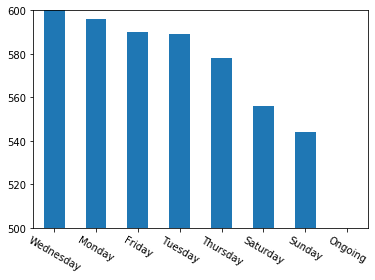

In [31]:
df_minus_ongoing['Day'].value_counts().plot.bar(ylim=[500, 600], rot=330)

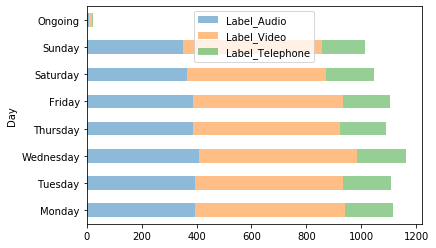

In [32]:
df.groupby('Day').sum().filter(regex='Video|Audio|Telephone').plot.barh(stacked=True, alpha=0.5)

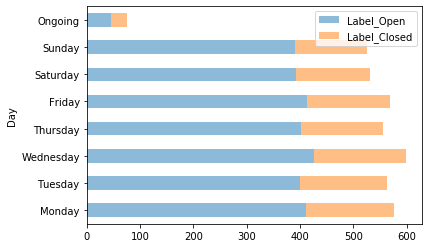

In [100]:
df.groupby('Day').sum().filter(regex='Open|Closed').plot.barh(stacked=True, alpha=0.5)

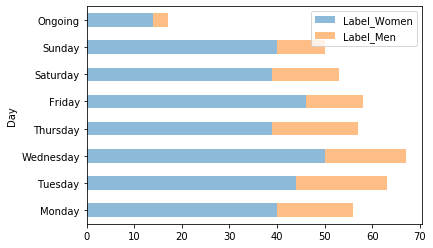

In [101]:
df.groupby('Day').sum().filter(regex='Men|Women').plot.barh(stacked=True, alpha=0.5)

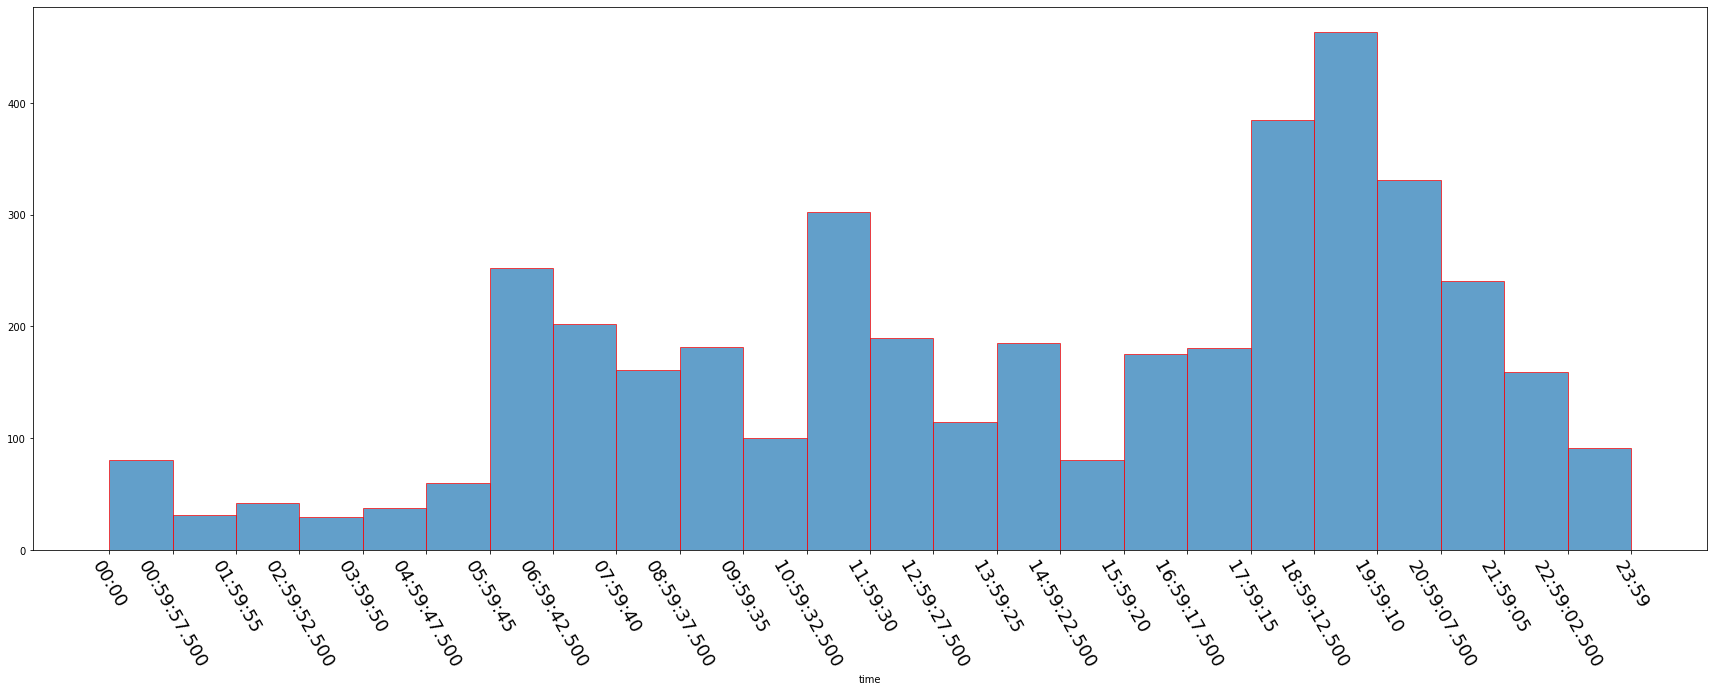

In [170]:
# Pandas' hist does not register this as numeric data, interestingly
plt.figure(figsize=(30,10))
n, bins, edges = plt.hist(df['Time_dt'],bins=24,ec="red",alpha=0.7)
plt.xticks(bins, rotation=300, fontsize=18)
plt.show()

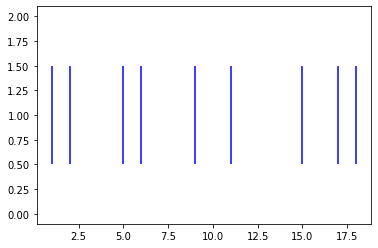

In [174]:
plt.figure()
a = [1,2,5,6,9,11,15,17,18]
plt.eventplot(a, orientation='horizontal', colors='b')
# plt.axis('off')
plt.show()